In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Load the merged data
df = pd.read_csv("merged.csv")

# Convert 'NoEvent', 'Unknown', 'Not Applicable' to 0
df.replace(["NoEvent", "Unknown", "Not Applicable"], 0, inplace=True)

#Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("\n🧾 Here are all your cleaned column names:\n")
print(df.columns.tolist())


🧾 Here are all your cleaned column names:

['ee_#', 'job_title', 'current_employment_status', 'project', 'project_code', 'original_hire_date', 'last_hire_date', 'los_in_days', 'termination_date', 'reason_code', 'left', 'fired', 'promotion_date', 'demotion_date', 'rehire_date', 'transfer_in_date', 'transfer_out_date', 'days_since_promotion', 'days_since_demotion', 'days_since_rehire', 'days_since_transfer_in', 'days_since_transfer_out', 'days_since_termination', 'flsa_exempt']


In [7]:
# Install XGBoost
!pip install xgboost --quiet

# Encode categorical features
categorical_cols = ['job_title', 'project_code', 'flsa_exempt']
for col in categorical_cols:
    if col in df.columns:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    else:
        print(f"⚠️ Column '{col}' not found in dataset — skipping.")

# Create churn column based on 'left' and 'fired'
df['churn'] = ((df['left'] == 1) | (df['fired'] == 1)).astype(int)

# Check class distribution
print(df['churn'].value_counts())

# Redefine features and target (in case you've run other blocks)
features = ['days_since_promotion', 'days_since_demotion', 'days_since_transfer_in',
            'days_since_transfer_out', 'days_since_rehire', 'job_title',
            'project_code', 'flsa_exempt', 'los_in_days']
X = df[features].apply(pd.to_numeric, errors='coerce').fillna(0)
y = df['churn']

# Train-test split with stratify to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred_xgb))


churn
0    7242
1    5122
Name: count, dtype: int64
Confusion Matrix:
 [[1874  299]
 [ 366 1171]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85      2173
           1       0.80      0.76      0.78      1537

    accuracy                           0.82      3710
   macro avg       0.82      0.81      0.81      3710
weighted avg       0.82      0.82      0.82      3710


Accuracy Score: 0.8207547169811321


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:55:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


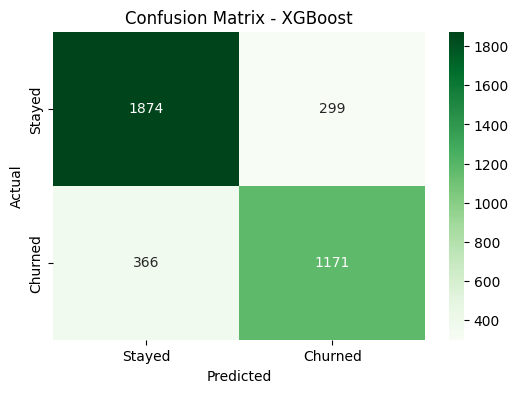

<Figure size 1000x600 with 0 Axes>

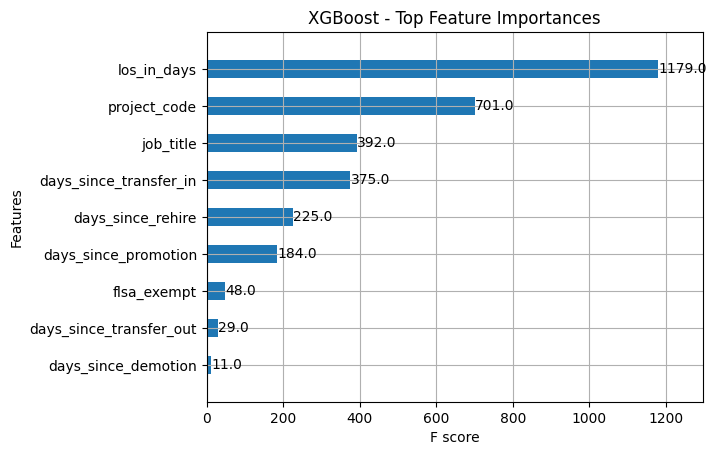

In [8]:
# Confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Stayed', 'Churned'], yticklabels=['Stayed', 'Churned'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.title('XGBoost - Top Feature Importances')
plt.show()
